In [1]:

import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import residual_GAN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# discriminator

In [3]:
discriminator = residual_GAN.Discriminator().to(device)

# generator

In [4]:
generator = residual_GAN.Generator(noise_dim=2048).to(device)

# other utilities

In [20]:
loss_fn = torch.nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-4)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=8e-4)

In [6]:
def noise_generator(device,batch_size=64, dimension=2048):
    return torch.randn((batch_size, dimension)).to(device)

# data pipeline

In [7]:
img_transforms = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [8]:
folder = "../../Datasets/annotated_img/images/train2017"

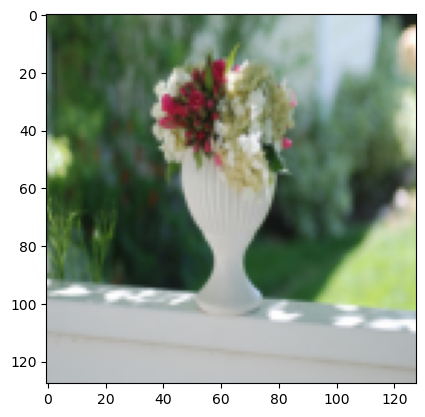

In [9]:
image = folder + "/000000000030.jpg"
image = Image.open(image).convert("RGB")
image_transformed = img_transforms(image)
plt.imshow(np.array(image_transformed).transpose(1,2,0))

In [10]:
from image_dataset import image_dataset

In [11]:
train_dataset = image_dataset(folder,img_transforms)

In [12]:
len(train_dataset)

118287

In [13]:
from torch.utils.data import RandomSampler
batch_size = 64
num_samples = 19200
train_sampler = RandomSampler(train_dataset,replacement=False,num_samples=num_samples)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)

# training routine

In [14]:
from torch_snippets import *

In [15]:

model_name = "resnet_300M"
if not os.path.exists(model_name):
    os.makedirs(model_name)


In [27]:
def train_discriminator(discriminator, real_data, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real, torch.ones((len(real_data),1)).to(device))
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake, torch.zeros((len(fake_data),1)).to(device))
    loss = loss_real * 2.5 + loss_fake
    loss.backward()
    optimizer.step()
    return loss_real, loss_fake

In [17]:
def train_generator(discriminator, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake,torch.ones((len(fake_data),1)).to(device))
    loss_fake.backward()
    optimizer.step()
    return loss_fake

EPOCH: 1.000  d_fake_floss: 0.780  d_loss: 1.056  g_loss: 1.647  d_real_loss: 0.276  (267.37s - 1336.85s remaining)
EPOCH: 2.000  d_fake_floss: 1.062  d_loss: 1.466  g_loss: 0.627  d_real_loss: 0.404  (522.09s - 1044.17s remaining)
EPOCH: 3.000  d_fake_floss: 0.918  d_loss: 1.282  g_loss: 0.645  d_real_loss: 0.364  (801.87s - 801.87s remaining))
EPOCH: 4.000  d_fake_floss: 0.823  d_loss: 1.151  g_loss: 0.849  d_real_loss: 0.327  (1068.35s - 534.18s remaining)
EPOCH: 5.000  d_fake_floss: 1.032  d_loss: 1.417  g_loss: 0.627  d_real_loss: 0.385  (1346.89s - 269.38s remaining)
EPOCH: 6.000  d_fake_floss: 1.121  d_loss: 1.519  g_loss: 0.446  d_real_loss: 0.398  (1611.27s - 0.00s remaining)))


100%|██████████| 107/107 [00:00<00:00, 2396.40it/s]


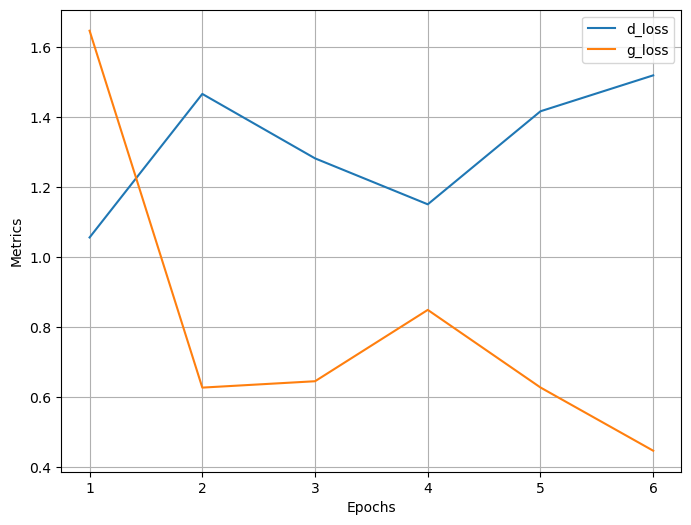

In [21]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 6
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(),
                   end = '\r')
    log.report_avgs(epoch+1)
torch.save(generator.state_dict(),model_name+"/generator.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
log.plot_epochs(['d_real_loss','d_fake_loss','g_loss'])

100%|██████████| 107/107 [00:00<00:00, 1522.57it/s]


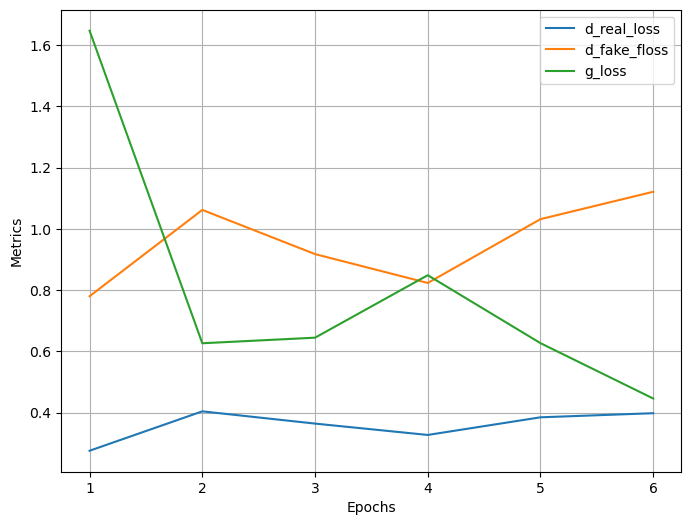

In [22]:
log.plot_epochs(['d_real_loss','d_fake_floss','g_loss'])

In [19]:
torch.save(generator.state_dict(),model_name+"/generator.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")

In [23]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=2e-4)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=8e-4)

In [18]:
# generator.load_state_dict(torch.load("resnet_300M\generator.pth"))
# discriminator.load_state_dict(torch.load("resnet_300M\discriminator.pth"))

<All keys matched successfully>

EPOCH: 1.000  d_fake_loss: 1.028  d_loss: 1.416  g_loss: 0.548  d_real_loss: 0.388  (256.63s - 1283.16s remaining)
EPOCH: 2.000  d_fake_loss: 0.961  d_loss: 1.342  g_loss: 0.665  d_real_loss: 0.381  (509.98s - 1019.96s remaining)
EPOCH: 3.000  d_fake_loss: 0.746  d_loss: 1.044  g_loss: 1.093  d_real_loss: 0.298  (763.74s - 763.74s remaining))
EPOCH: 4.000  d_fake_loss: 0.930  d_loss: 1.300  g_loss: 0.765  d_real_loss: 0.369  (1017.35s - 508.68s remaining)
EPOCH: 5.000  d_fake_loss: 0.971  d_loss: 1.338  g_loss: 0.706  d_real_loss: 0.367  (1271.69s - 254.34s remaining)
EPOCH: 6.000  d_fake_loss: 0.847  d_loss: 1.190  g_loss: 0.841  d_real_loss: 0.343  (1526.30s - 0.00s remaining)))


100%|██████████| 107/107 [00:00<00:00, 1567.03it/s]


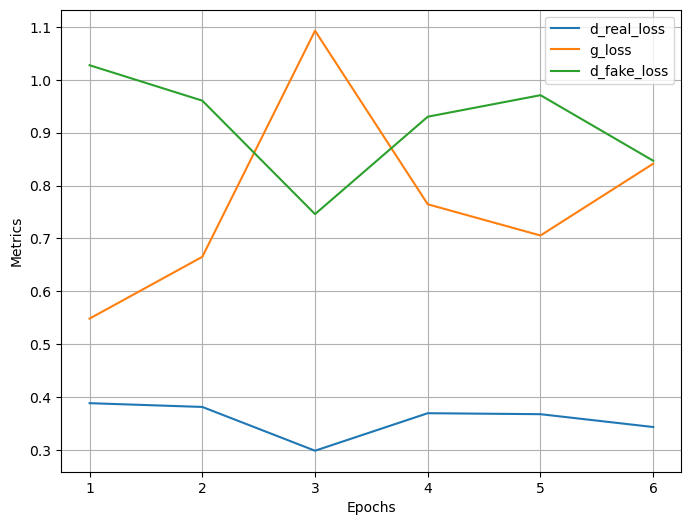

In [24]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 6
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(),
                   end = '\r')
    log.report_avgs(epoch+1)
torch.save(generator.state_dict(),model_name+"/generator.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
log.plot_epochs(['d_real_loss','g_loss','d_fake_loss'])

In [25]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=2e-4)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=6e-4)

EPOCH: 1.000  d_fake_loss: 0.835  d_loss: 1.168  g_loss: 0.848  d_real_loss: 0.333  (257.30s - 1801.07s remaining)
EPOCH: 2.000  d_fake_loss: 0.805  d_loss: 1.134  g_loss: 0.858  d_real_loss: 0.329  (511.61s - 1534.84s remaining)
EPOCH: 3.000  d_fake_loss: 0.538  d_loss: 0.766  g_loss: 1.589  d_real_loss: 0.228  (765.69s - 1276.16s remaining)
EPOCH: 4.000  d_fake_loss: 0.667  d_loss: 0.933  g_loss: 1.382  d_real_loss: 0.267  (1021.26s - 1021.26s remaining)
EPOCH: 5.000  d_fake_loss: 0.694  d_loss: 0.985  g_loss: 1.523  d_real_loss: 0.291  (1276.18s - 765.71s remaining))
EPOCH: 6.000  d_fake_loss: 0.656  d_loss: 0.930  g_loss: 1.334  d_real_loss: 0.275  (1530.11s - 510.04s remaining)
EPOCH: 7.000  d_fake_loss: 0.592  d_loss: 0.827  g_loss: 1.504  d_real_loss: 0.235  (1783.74s - 254.82s remaining)
EPOCH: 8.000  d_fake_loss: 0.506  d_loss: 0.705  g_loss: 2.238  d_real_loss: 0.199  (2037.21s - 0.00s remaining)))


100%|██████████| 109/109 [00:00<00:00, 1333.70it/s]


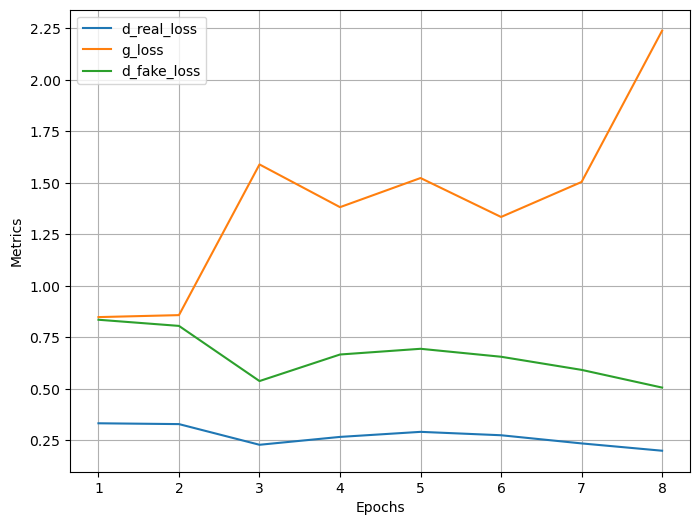

In [26]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 8
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(),
                   end = '\r')
    log.report_avgs(epoch+1)
torch.save(generator.state_dict(),model_name+"/generator.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
log.plot_epochs(['d_real_loss','g_loss','d_fake_loss'])

In [28]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-4)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=6e-4)

EPOCH: 1.000  d_fake_loss: 0.863  d_loss: 1.103  g_loss: 1.424  d_real_loss: 0.241  (254.03s - 1778.20s remaining)
EPOCH: 2.000  d_fake_loss: 0.944  d_loss: 1.216  g_loss: 0.688  d_real_loss: 0.272  (507.66s - 1522.97s remaining)
EPOCH: 3.000  d_fake_loss: 0.851  d_loss: 1.115  g_loss: 0.852  d_real_loss: 0.264  (760.57s - 1267.61s remaining)
EPOCH: 4.000  d_fake_loss: 0.920  d_loss: 1.182  g_loss: 0.805  d_real_loss: 0.262  (1013.58s - 1013.58s remaining)
EPOCH: 5.000  d_fake_loss: 0.798  d_loss: 1.043  g_loss: 0.974  d_real_loss: 0.245  (1266.96s - 760.18s remaining))
EPOCH: 6.000  d_fake_loss: 0.775  d_loss: 1.011  g_loss: 0.995  d_real_loss: 0.236  (1521.06s - 507.02s remaining)
EPOCH: 7.000  d_fake_loss: 0.922  d_loss: 1.190  g_loss: 0.814  d_real_loss: 0.268  (1774.77s - 253.54s remaining)
EPOCH: 8.000  d_fake_loss: 0.985  d_loss: 1.278  g_loss: 0.727  d_real_loss: 0.293  (2028.72s - 0.00s remaining)))


100%|██████████| 109/109 [00:00<00:00, 1264.12it/s]


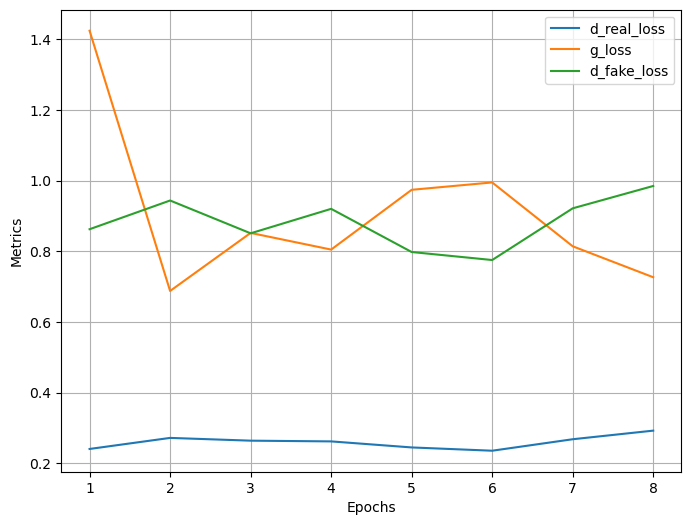

In [29]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 8
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(),
                   end = '\r')
    log.report_avgs(epoch+1)
torch.save(generator.state_dict(),model_name+"/generator.pth")
torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
log.plot_epochs(['d_real_loss','g_loss','d_fake_loss'])

tensor([[0.0019]], device='cuda:0', grad_fn=<SigmoidBackward0>)

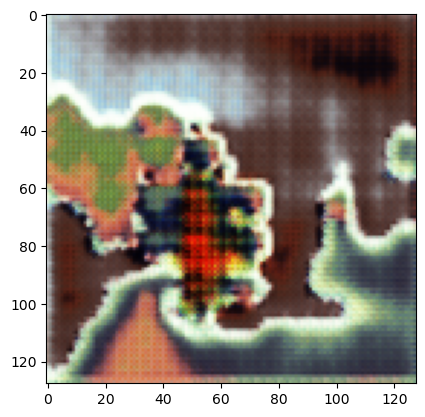

In [44]:
img = generator(noise_generator(device,1,2048)).to(device)
print(torch.nn.Sigmoid()(discriminator(img)))
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

In [33]:
p = 0
while p < 0.5:
    img = generator(noise_generator(device,1,2048)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

KeyboardInterrupt: 

0.9233351349830627

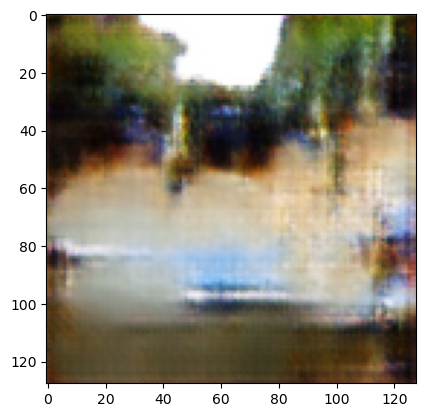

In [ ]:
p = 0
while p < 0.7:
    img = generator(noise_generator(device,1,2048)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

0.9158802628517151

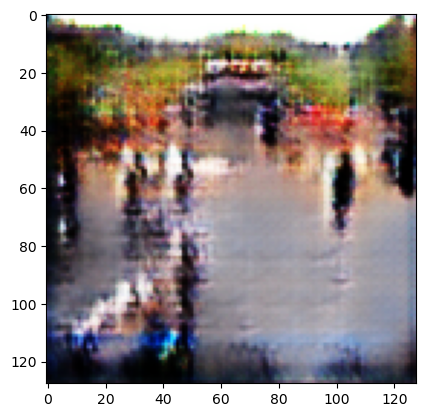

In [ ]:
p = 0
while p < 0.9:
    img = generator(noise_generator(device,1,2048)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)